# Fast and Scalable Timeseries Modelling with Fugue and Nixtla

This tutorial will be about scaling time series modelling to Spark, Dask, and Ray. Timeseries data is very friednly to distributed computing because we normally have hundreds or thousands of relatively independent data points. We can pre-process and model each one independently. This set-up allows choosing the best model for each timeseries.

The main tools used in this tutorial are:

[Nixtla](https://github.com/Nixtla) - The Nixtla project is focused lightning fast state-of-the-art timeseries modelling. The project has a few libraries
* [statsforecast](https://github.com/Nixtla/statsforecast) - focused on statistic and econometric models such as ARIMA, ETS 
* [neuralforecast](https://github.com/Nixtla/neuralforecast) - neural forecasting algorithms for time series data
* [hierarchicalforecast](https://github.com/Nixtla/hierarchicalforecast) - hierarchichal forecasting with statistical and econometric methods
* [mlforecast](https://github.com/Nixtla/mlforecast) - using models such as gradient boosted trees for forecasting

[Fugue](https://github.com/fugue-project/fugue/) - an abstraction layer for Spark, Dask, and Ray. Fugue ports code written for local execution to distributed execution.

[Ray](https://github.com/ray-project/ray) (on [Anyscale](https://www.anyscale.com/)) - a distributed computing engine.

[MLFlow](https://github.com/mlflow/mlflow) - a framework for experiment tracking.


## Loading Data

The data has been placed in a public S3 bucket for this tutorial. We will be using the data from Kaggle's [M5 Forecasting Accuracy](https://www.kaggle.com/competitions/m5-forecasting-accuracy) competition. This contains Walmart sales data for the USA.

We are working with **42,840 hierarchical time series**. The data were obtained in the 3 US states of California (CA), Texas (TX), and Wisconsin (WI). “Hierarchical” here means that data can be aggregated on different levels: item level, department level, product category level, and state level. The sales information reaches back from Jan 2011 to June 2016. In addition to the sales numbers, we are also given corresponding data on prices, promotions, and holidays. Note, that we have been warned that most of the time series contain zero values.

The data comprises 3049 individual products from 3 categories and 7 departments, sold in 10 stores in 3 states. The hierachical aggregation captures the combinations of these factors. For instance, we can create 1 time series for all sales, 3 time series for all sales per state, and so on. The largest category is sales of all individual 3049 products per 10 stores for 30490 time series.

We start by downloading and unzipping the contents. This will give us the CSV files to work with.

In [15]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import zipfile
import os

download_path = os.path.join(".","..","data","m5-forecasting-accuracy.zip")
unzipped_path = os.path.join(".","..","data","m5-forecasting-accuracy-unzipped")

s3 = boto3.client('s3', region_name='us-east-2', config=Config(signature_version=UNSIGNED))
s3.download_file('fugue-data', 'm5-forecasting-accuracy.zip', download_path)

with zipfile.ZipFile(download_path,"r") as zip_ref:
    zip_ref.extractall(unzipped_path)

os.remove(download_path)


## First Look at Data

We'll take a quick look at the data given to us to understand the problem more. Most of the code snippets here are taken from [Rob Mulla's Starter Notebook](https://www.kaggle.com/code/robikscube/m5-forecasting-starter-data-exploration). We're not going to go to deep to understand everything. We're only interested in setting up an end-to-end modelling pipeline.

In [56]:
import pandas as pd

# Read in the data
INPUT_DIR = unzipped_path
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
training_data = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
sell_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')


**Training Data**

We take a look at the head. Note the following:
1. There is a hierarchichal nature to the data. There is a `dept_id` and a `cat_id`. 
2. A `store_id` + `item_id` is a unique identifier
3. Columns `d_1` to `d_1913` form our timeseries of purchases

In [22]:
training_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


**Sell Prices**

In [18]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


**Calendar**

We need to join `training_data` with `calendar` data by `wm_yr_wk` we can map the prices to dates

In [17]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


## Initial Plots

We are not too concerned with getting the best model. We just want to understand the data better and what the timeseries looks like.

In [26]:
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle

plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

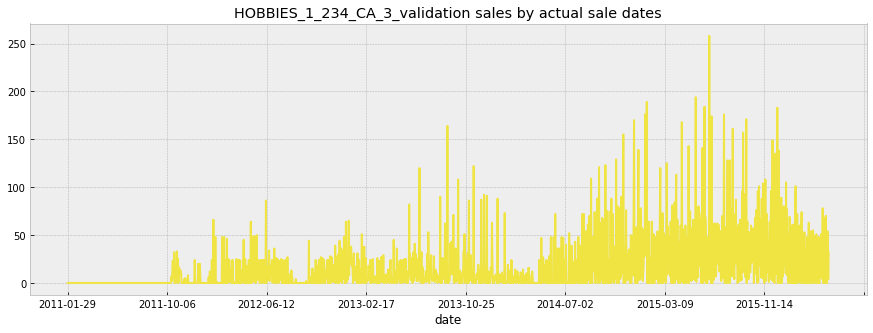

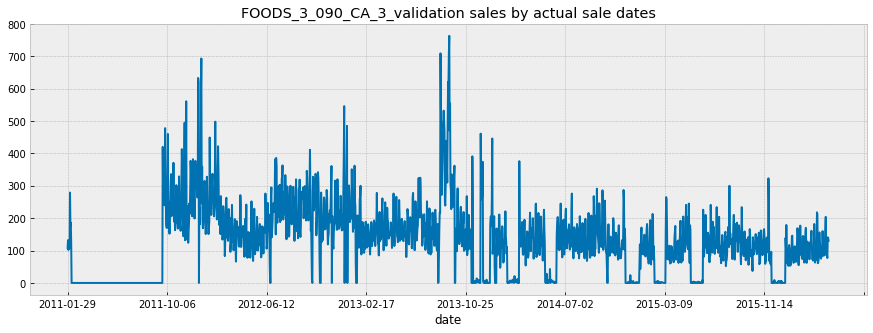

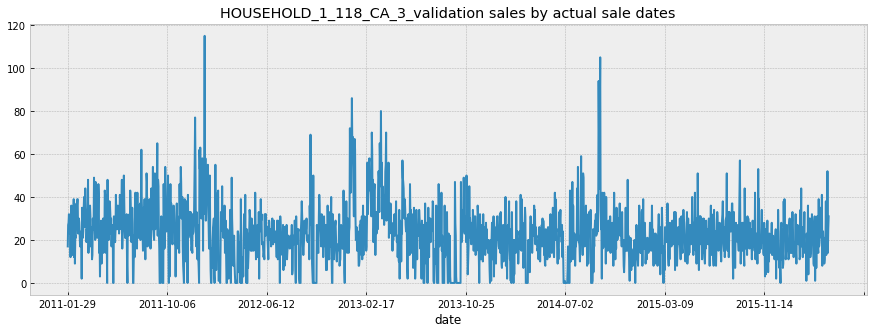

In [78]:
d_cols = [c for c in training_data.columns if 'd_' in c] # sales data columns

def plot_one(data: pd.DataFrame, calendar: pd.DataFrame, id: str) -> None:
    data = data.loc[data['id'] == id].copy(deep=True)
    idx = data.index.values[0]
    example = (
        data[d_cols]\
        .T\
        .rename(columns={str(idx):id})\
        .reset_index()\
        .rename(columns={'index': 'd'})\
        .merge(calendar, how='left', validate='one_to_one')\
        .set_index('date')[idx]
    )
    example.plot(figsize=(15, 5),
            color=next(color_cycle),
            title=f'{id} sales by actual sale dates')
    plt.show()
    return

plot_one(training_data, calendar, 'HOBBIES_1_234_CA_3_validation')
plot_one(training_data, calendar, 'FOODS_3_090_CA_3_validation')
plot_one(training_data, calendar, 'HOUSEHOLD_1_118_CA_3_validation')

In [ ]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

In [ ]:
examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
example_df = [example, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              color=color_pal[0],
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5,
              color=color_pal[4],

              ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',
              color=color_pal[2],

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

In [ ]:
twenty_examples = stv.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

In [23]:
def read_calendar() -> pd.DataFrame:
    df = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
    df["date"] = pd.to_datetime(df["date"])
    return df.set_index("date").sort_index()

# We need the start and end of the calendar to pad the dates
CALENDAR = read_calendar()
CALENDAR_START = CALENDAR.index[0].date()
CALENDAR_END = CALENDAR.index[-1].date()

def get_no_event_dates(df:pd.DataFrame) -> pd.Series:
    return df[df.event_name_1.isnull() & df.event_name_2.isnull()].index

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
date,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
